# Referential Language Game with Compositional Inputs: Evaluation

### Import of Libaries and definition of some functions

In [14]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from egg import core
from os.path import normpath
import os
from torch.nn import Module
from torch.optim import Adam
from torch import save
from egg.core import Interaction
import matplotlib.pyplot as plt
from rlg.architectures import *
from rlg.loss import *
import rlg
import tqdm
import numpy as np
from PIL.Image import open as im_open
import itertools 
import random
import re
%matplotlib inline

In [15]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def get_n_gram(n,messages):
    "Compute the n-gram model of given n and given sentences"
    n_gram = {}
    for i in range(len(messages)):
        for x in range(len(messages[i])-n+1):
            if messages[i][x:x+n] in n_gram.keys():
                n_gram[messages[i][x:x+n]] += 1
            else:
                n_gram[messages[i][x:x +n]] = 1

    sorted_n_gram = {k: v for k, v in sorted(n_gram.items(), key=lambda item: item[1],reverse=True)}
    return sorted_n_gram


## Comparison of the loss and log-probs of REINFORCE and Gumbel-softmax

### Comparison of test loss

The loss on the testset during training can give valuable insights into the training speed. Training should be terminated when the test loss is minimal. Before that, there is still potential for improvement. Training too long, on the other hand, can lead to an overfit and even increase in the test loss.

In the first graph the training of two models over 30 epochs is shown. It seems as if both models converge at a similar value around the 30th epoch. For being sure, longer training would be nessecary. The model, that was trained with gumbel softmax, took a substantially longer amount of training time, for the same number of epochs.

In the second graph the training of a second reinforce model can be seen. This one was trained for 120 epochs. For comparison, the first reinforce model has been overlayed over the last 30 epochs. Allthough it seems, that there was a lot of bad luck involved in the initialization of the second model, in the end it manages to surpass the performance of the first one.

For evaluating the full potential of the reinforcement setup, even longer training is required, as well as the training of several models in parallel in order to correct statistical artifacts.

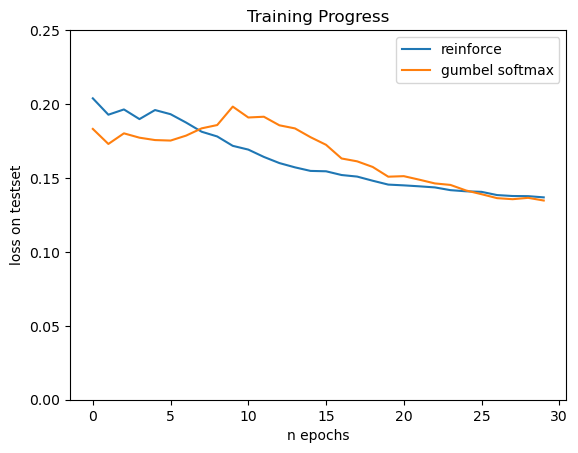

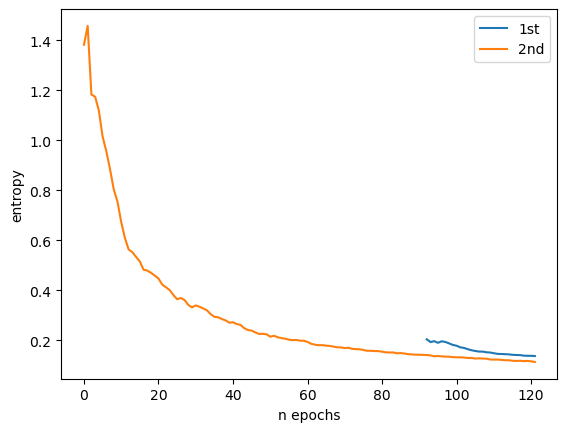

In [7]:
with open("logs/log_test_loss_RE_25_Epochs.txt", "r") as file:
    loss_reinf = file.read()
loss_reinf = re.findall(r"[-+]?\d*\.\d+|\d+", loss_reinf)
loss_reinf_numbers = []
for loss in loss_reinf:
    try:
        loss_reinf_numbers.append(float(loss))
    except:
        pass
    
    
with open("logs/log_gs_test_loss_4_5.txt", "r") as file:
    loss_gs = file.read()
loss_gs = re.findall(r"[-+]?\d*\.\d+|\d+", loss_gs)
loss_gs_numbers = []
for loss in loss_gs:
    try:
        loss_gs_numbers.append(float(loss))
    except:
        pass
    
epochs = np.arange(0, len(loss_reinf_numbers), 1, dtype=int)

fig, ax = plt.subplots(1,1)
ax.plot(epochs,loss_reinf_numbers,label="reinforce")
ax.plot(epochs,loss_gs_numbers,label="gumbel softmax")
ax.set(ylabel="loss on testset",
      xlabel="n epochs",
      title="Training Progress")
ax.set_ylim(0, 0.25)

plt.legend()
plt.show()


with open("logs/log_REINF_4_5_120Epochs.txt", "r") as file:
    loss_long = file.read()
loss_long = re.findall(r"[-+]?\d*\.\d+|\d+", loss_long)
loss_long_numbers = []
for loss in loss_long:
    try:
        loss_long_numbers.append(float(loss))
    except:
        pass
    
epochs_long = np.arange(0, len(loss_long_numbers), 1, dtype=int)
epochs = np.arange(len(loss_long_numbers)-len(loss_reinf_numbers), len(loss_long_numbers), 1, dtype=int)

fig, ax = plt.subplots(1,1)
ax.plot(epochs,loss_reinf_numbers,label="1st")
ax.plot(epochs_long,loss_long_numbers,label="2nd")
ax.set(ylabel="entropy",
      xlabel="n epochs",)

plt.legend()
plt.show()
   

### Comparison of Entropies

Both, reinforce and gumbel softmax, use sampling from a categorical distribution for creating messages. The entropy of these distributions during training can be viewed as the amount of confidence that the sender has in its messages. This is especially true for reinforce, where a high confidence in the choosen action results in a high reward.

As long as entropy is high, there is a lot of randomness in the generated messages. This makes it extremely hard for the receiver to learn anything. In the reinforce game, after 30 epochs the entropy changes only little. Therefore training should not be done in less epochs. In the gumbel softmax game, no decrease in entropy can be seen. This can have multiple reasons, first of all the high temperature (i.e. sampling greediness) that was used. For a better analysis an exhaustive hyperparameter search would be required (Grid Search).

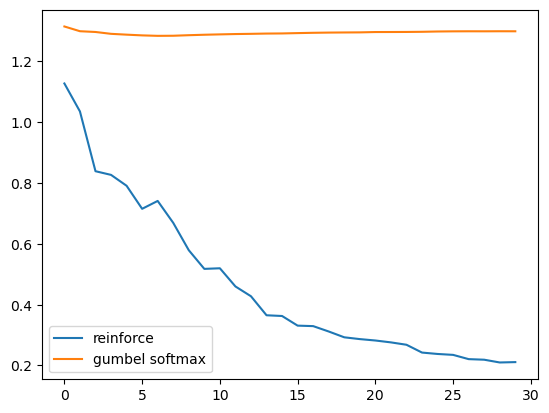

In [19]:
with open("logs/log_Entropy_RE_25_Epochs.txt", "r") as file:
    ent_reinf = file.read()
ent_reinf = re.findall(r"[-+]?\d*\.\d+|\d+", ent_reinf)
ent_reinf_numbers = []
for ent in ent_reinf:
    try:
        ent_reinf_numbers.append(float(ent))
    except:
        pass
    
    
with open("logs/log_gs_entropy_4_5.txt", "r") as file:
    ent_gs = file.read()
ent_gs = re.findall(r"[-+]?\d*\.\d+|\d+", ent_gs)
ent_gs_numbers = []
for ent in ent_gs:
    try:
        ent_gs_numbers.append(float(ent))
    except:
        pass
    
epochs = np.arange(0, len(ent_reinf_numbers), 1, dtype=int)

fig, ax = plt.subplots(1,1)
ax.plot(epochs,ent_reinf_numbers,label="reinforce")
ax.plot(epochs,ent_gs_numbers,label="gumbel softmax")

plt.legend()
plt.show()

## Loading of the trained game and the data used for evaluation

Set up of the agents and the game

In [3]:
vision = rlg.Vision()
class_prediction = rlg.PretrainVision(vision)
class_prediction.load_state_dict(torch.load('./models/class_prediction.pth', map_location=torch.device('cpu')))

# Agent's and game's setup
sender = rlg.Sender(class_prediction.vision_module)
receiver = rlg.Receiver()
game = rlg.LanguageGame(sender, receiver, sender_entropy_coeff=0.005, receiver_entropy_coeff=0.000)
game.load_state_dict(torch.load('./models/game_REINF_4_5_120Epochs.pth'))

<All keys matched successfully>

Loading of some new test data, i.e. 10000 pictures of squares, 10000 pictures of circles and 10000 pictures of triangles

In [22]:
test_shapes = {}
for shape in ["square", "circle", "triangle"]:
    custom_test_data = {}
    test_files = os.listdir("./data/eval/" + shape +"/")
    for i in range(len(test_files)):
        file = test_files[i]
        im = np.moveaxis(
            np.array(im_open("./data/eval/"+ shape + "/" + file)), 2,0) / 255.
        y = [float(value) for value in file[:-4].split(sep=', ')]
        custom_test_data[i] = (torch.tensor(im).to(dtype=torch.float32), torch.tensor(y))
    loader = torch.utils.data.DataLoader(custom_test_data, batch_size=len(test_files), shuffle=True)
    test_shapes[shape] = loader

Load of 20 samples from the original test dataset

In [4]:
_, test_data_loader = rlg.load_dataset(0.8)
#print(test_data_loader[0])

test_inputs = []
indices = random.sample(range(0, len(test_data_loader)), 20)
for index in indices:
    index = torch.tensor(index)
    img, _ = test_data_loader.dataset[index]
    test_inputs.append(img.unsqueeze(0))

test_inputs = torch.cat(test_inputs)
test_dataset = [[test_inputs, None]]

100%|█████████████████████████████████████| 7999/7999 [00:07<00:00, 1043.39it/s]


## Visual results of the Game
Here, we plot some input images, the message sent by the agents, and the output of the receiver agent to get an intuition if the agents are able to communicate at all.

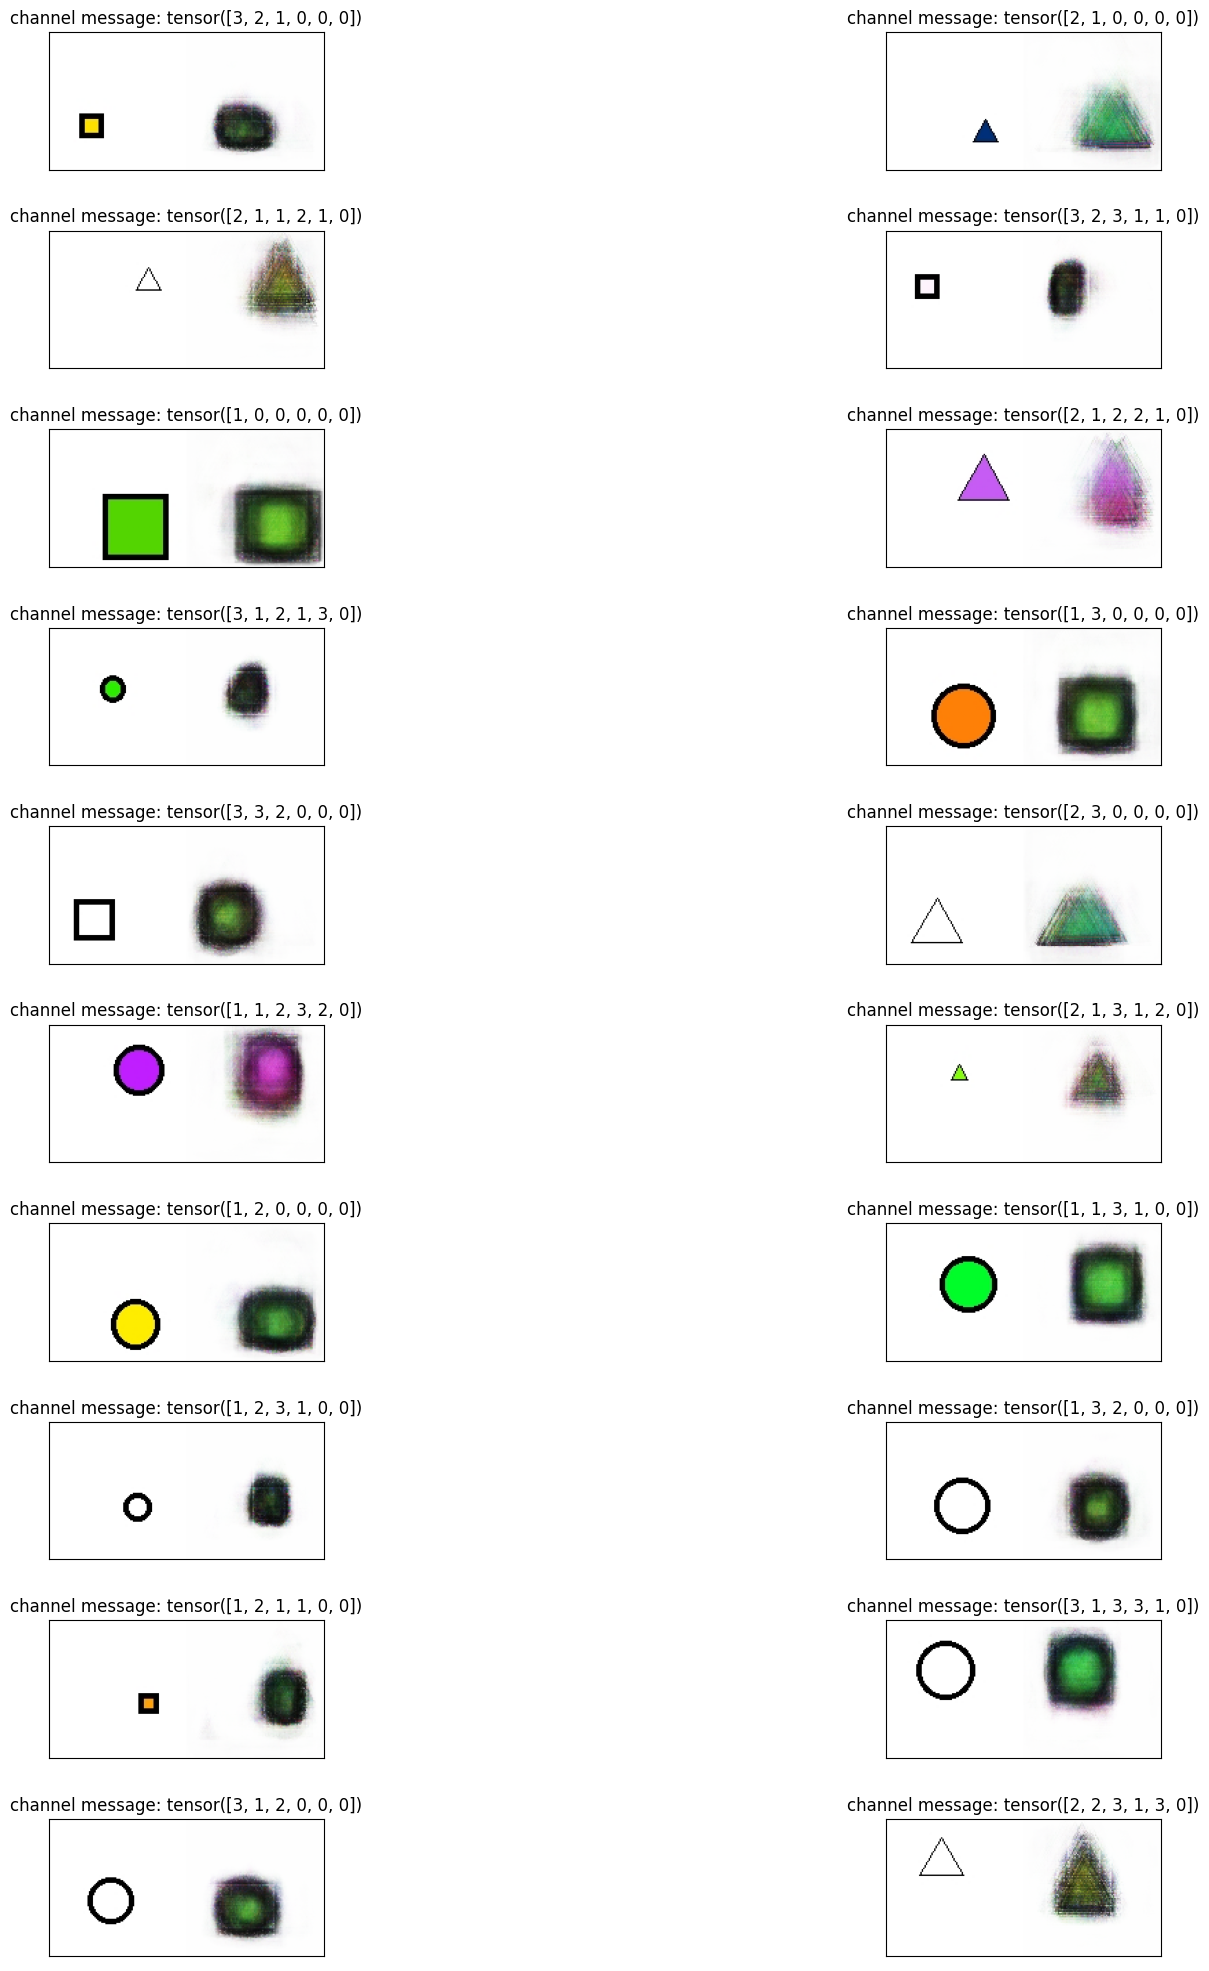

In [24]:
interaction = core.dump_interactions(game, test_dataset, gs=False, variable_length=True)

plots = []
titles = []
for z in range(20):
    src = interaction.sender_input[z].permute(1, 2, 0)
    dst = interaction.receiver_output[z].view(3, 100, 100).permute(1, 2, 0)
    interaction_message = interaction.message[z]

    image = torch.cat([src, dst], dim=1).cpu().numpy()
    title = (f"channel message: {interaction_message}")
    plt.title = title
    plots.append(image)
    titles.append(title)

fig = plt.figure(figsize=(20, 20))
fig.tight_layout()
columns = 2
rows = 10
for i in range(1, columns * rows + 1):
    img = plots[i - 1]
    img = img
    title = titles[i - 1]
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.gca().set_title(title)
    plt.imshow(img)

for i in fig.axes:
    i.set_xticks([])
    i.set_yticks([])
    
plt.show()

As we can see, the outcome if not perfect. The agents seem to struggle especially with the right color, especially if there isn't any color in the input image. We also see that the transmission of the shape triangle works better than the shapes square and circle. We think this is because squares and circles are more similar than squares/circles and triangles. Additionally, we observe that the agents struggle with the shape of small triangles. The game could be improved by custimizing the loss function (We costimized the loss function to weight colored pixels more than white pixels, because most of the input image is white. We did so to prevent the agents to only produce white/gray output images. Now we see that your weightening was a little bit too strong).

## N-Gram Analysis

In the following, we will compute the 1-, 2- and 3-Gram Language Models of 10000 example sentences (=messages), which all encode the same geometric shape. We will compute three models, one for squares, one for triangles and one for circles and compare the n-gram models. We hope to identify the symbol or sequence of symbols that encodes the respective shape. 
On the x-axis of the plots, we see the 10 most frequent n-grams (except for the 1-gram case, because the messages only contain four 1-grams each), and on the y-axis their frequency.

In [8]:
# extract the messages from the game's interaction object, convert them to strings and format them
messages_shapes = {}
for shape in test_shapes.keys():
    interaction = core.dump_interactions(game, test_shapes[shape], gs=False, variable_length=True)
    messages = []
    for message in interaction.message:
        string = np.array2string(message.numpy(), separator='')[1:-1]
        for symbol in range(len(string)):
            if string[symbol] == "0":
                string = string[:symbol+1]
                break
                
        messages.append(string)
    messages_shapes[shape] = messages

In [9]:
# compute the n_grams
one_grams = {}
two_grams = {}
three_grams = {}
four_grams = {}
five_grams = {}

for shape in messages_shapes.keys():
    one_grams[shape] = get_n_gram(1,messages_shapes[shape])
    two_grams[shape] = get_n_gram(2,messages_shapes[shape])
    three_grams[shape] = get_n_gram(3,messages_shapes[shape])
    four_grams[shape] = get_n_gram(4,messages_shapes[shape])
    five_grams[shape] = get_n_gram(5,messages_shapes[shape])

    

n_grams = [one_grams,two_grams,three_grams,four_grams,five_grams] 

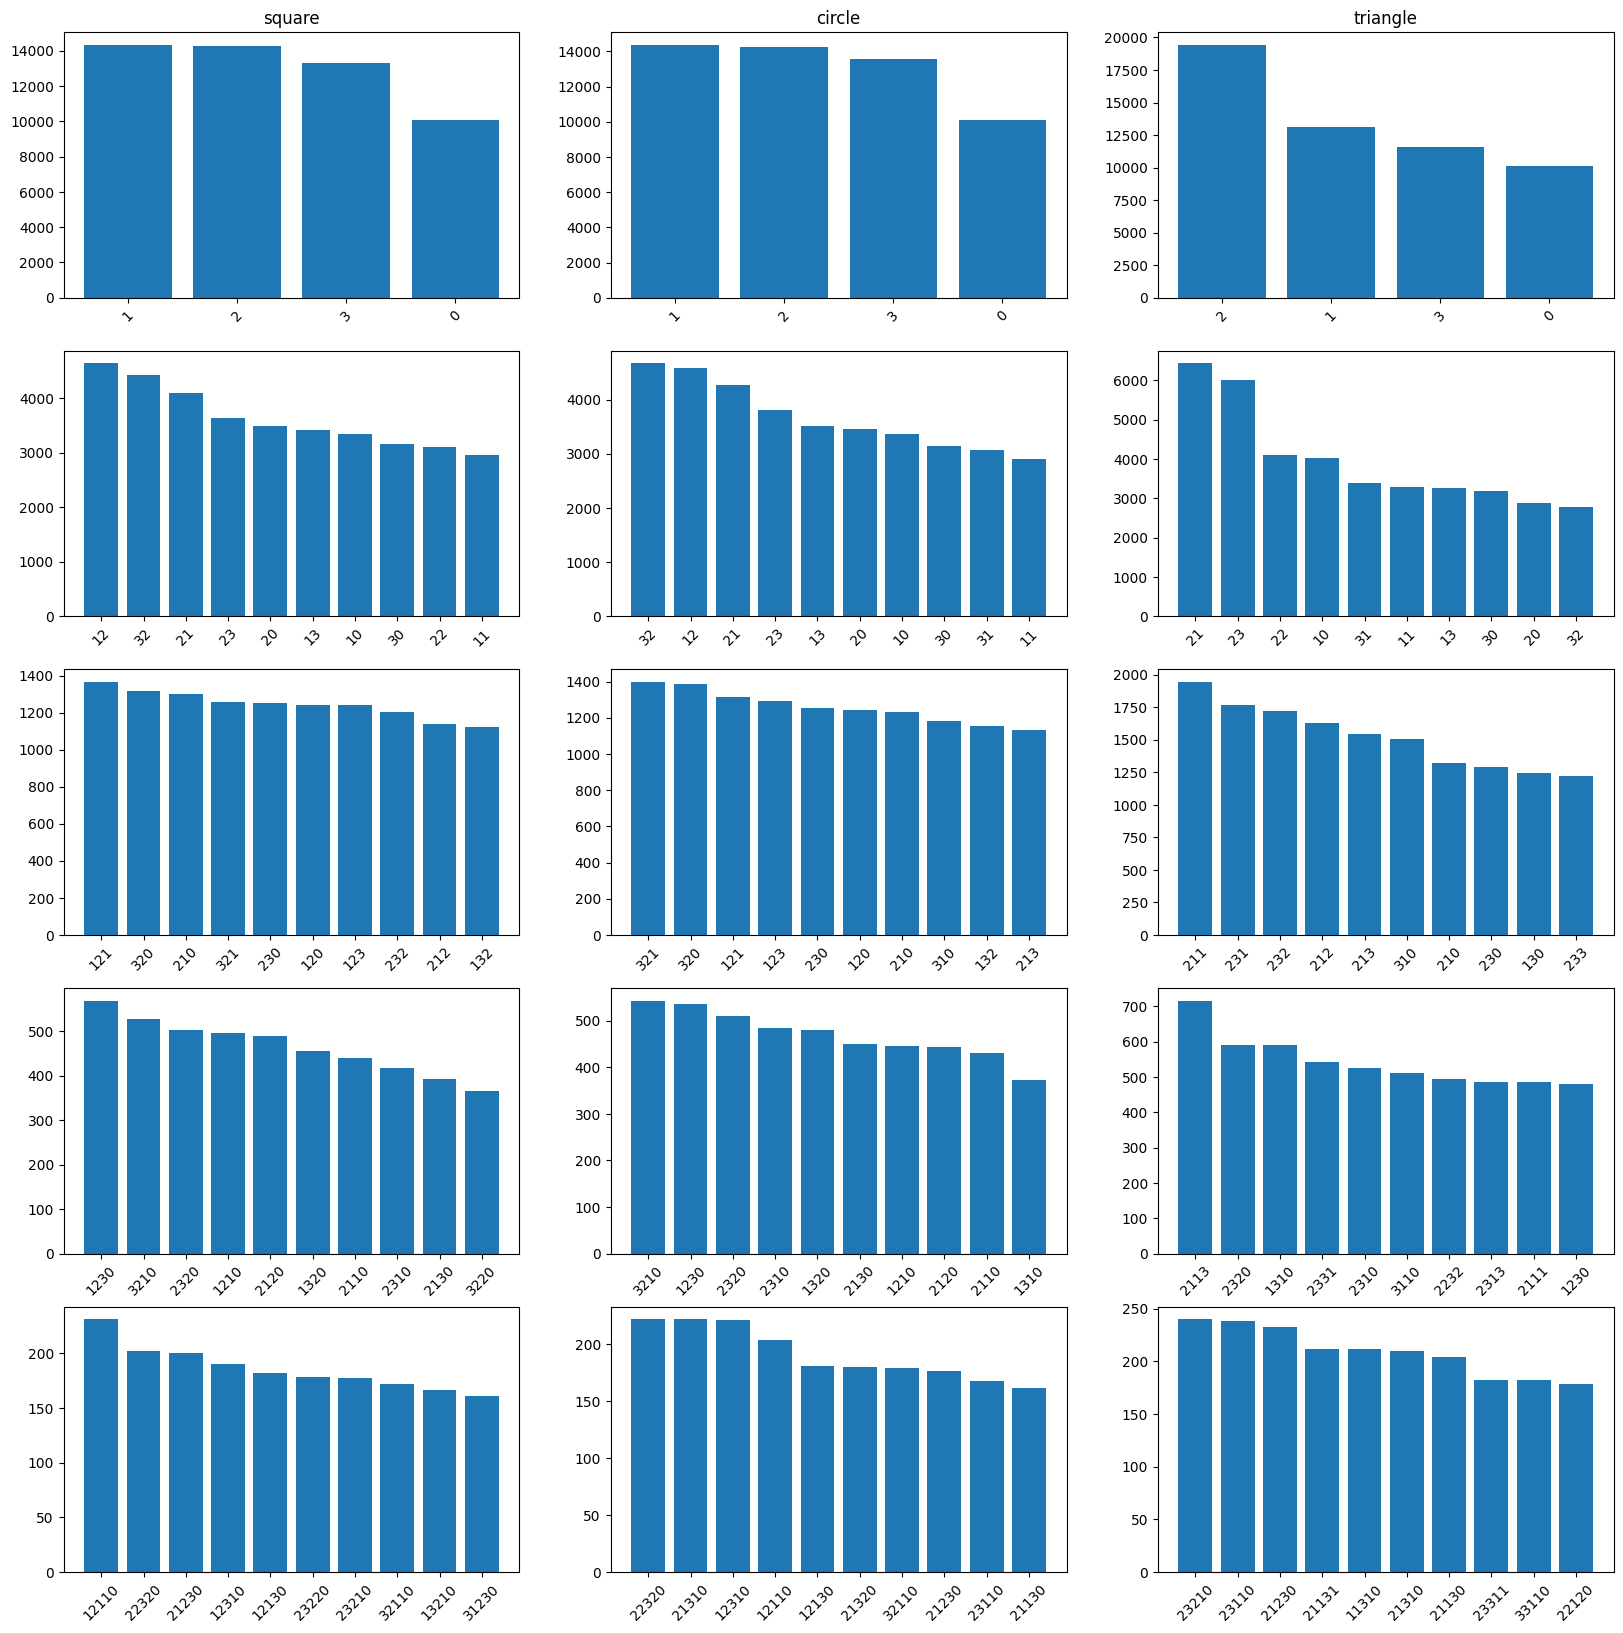

In [10]:
# print the n-grams
plot_data = []
xtick_data = []
for shape in messages_shapes.keys():
    plot_data.append(dict(itertools.islice(one_grams[shape].items(), 10)))
    plot_data.append(dict(itertools.islice(two_grams[shape].items(), 10)))
    plot_data.append(dict(itertools.islice(three_grams[shape].items(), 10)))
    plot_data.append(dict(itertools.islice(four_grams[shape].items(), 10)))
    plot_data.append(dict(itertools.islice(five_grams[shape].items(), 10)))

plot_data = (
    plot_data[0],
    plot_data[5],
    plot_data[10],
    plot_data[1],
    plot_data[6],
    plot_data[11],
    plot_data[2],
    plot_data[7],
    plot_data[12],
    plot_data[3],
    plot_data[8],
    plot_data[13],
    plot_data[4],
    plot_data[9],
    plot_data[14])

fig = plt.figure(figsize=(20,20))
#fig.tight_layout()
columns = 3
rows = 5

for i in range(1, columns * rows +1):
    fig.add_subplot(rows, columns, i)
    if i == 1:
        plt.gca().set_title("square")
    elif i == 2:
        plt.gca().set_title("circle")
    elif i == 3:
        plt.gca().set_title("triangle")
    plt.bar(range(len(plot_data[i-1])), list(plot_data[i-1].values()), align='center')
    plt.xticks(range(len(plot_data[i-1])),list(plot_data[i-1].keys()),rotation = 45)


We see that the n-grams for circles and squares are nearly identical. they share the same 1-gram and they differe only slightly in their other n-grams. The n-grams for triangle are different. They have a higher occurence of the number 2 for the 1-grams, and also a less uniform distribution for the other n-grams compared to squares and circles. This matches with the plots we see above under "Visual results of the Game". The agents are best at transmitting triangles, and less good for squares and circles. 

## Decaying message
Here we investigate how the messages encode the picture. For this purpose, we censecutively delete the last symbol of a message (setting it to the end of sequence symbol 0) and plot the receivers output to the message. We demonstrate this for one message which encodes a triangle.

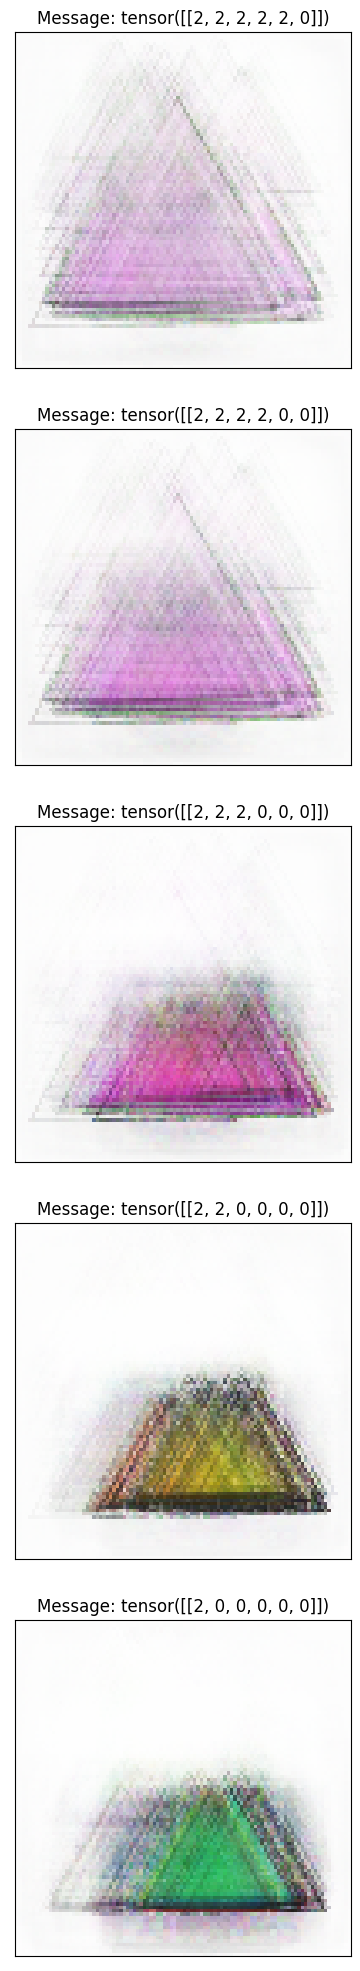

In [23]:
triangle = torch.tensor([[2, 2, 2, 2, 2, 0]])

messages_decaying = []
triangle = triangle.detach().numpy()
for index in range(len(triangle[0])):
    message_part = triangle[0][:index+1]
    zeros = np.zeros(len(triangle[0])-(index+1), dtype=int)
    messages_decaying.append(torch.tensor([np.concatenate((message_part,zeros))]))

    
generated_images = []
for message in messages_decaying:
    receiver_output = game.receiver(message)
    generated_images.append(receiver_output[0].view(3, 100, 100).permute(1, 2, 0).detach().numpy())
generated_images.reverse()
messages_decaying.reverse()
fig = plt.figure(figsize=(20,20))
fig.tight_layout()
columns = 1
rows = 5

for i in range(1, columns*rows +1):
    img = generated_images[i]
    title = "Message: " + str(messages_decaying[i])
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.gca().set_title(title)
    plt.imshow(img)
for i in fig.axes:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

As we see, the message starts with a 2, which is the most occuring number for transmitting triangles. Because of this, the shape stays more or less the same. Messages that start with 1 or 3 do not show any triangles (see images below). What changes are the color, the size and the position. In a next step, one could investigate the meaning of different numbers at the other locations, i.e. where and how the size, the position and the color is encoded. 

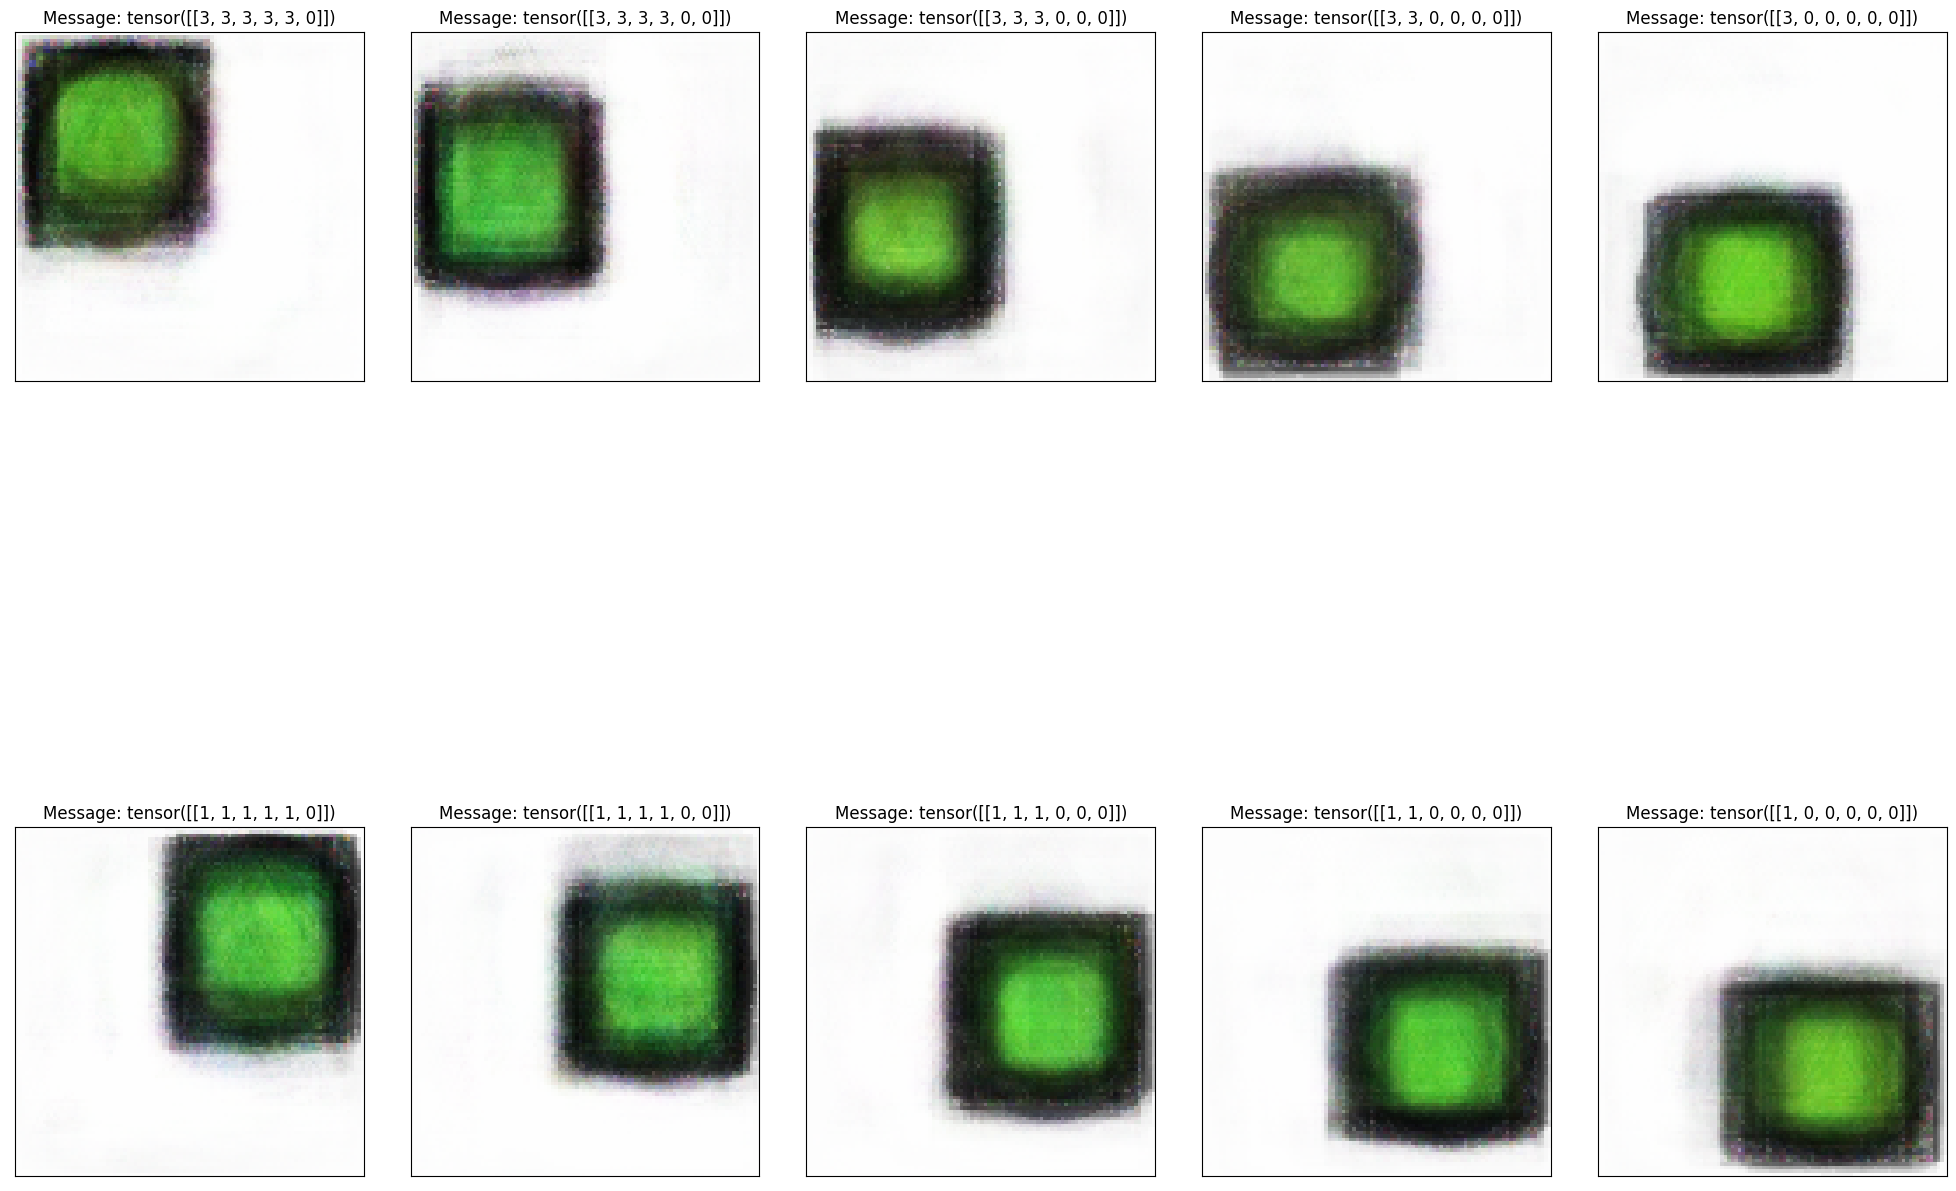

In [31]:
ones = torch.tensor([[1, 1, 1, 1, 1, 0]])
threes = torch.tensor([[3, 3, 3, 3, 3, 0]])
messages_decaying = []
ones = ones.detach().numpy()
thress = threes.detach().numpy()
other_messages = [ones,threes]
for message in other_messages:
    for index in range(len(triangle[0])-1):
        message_part = message[0][:index+1]
        zeros = np.zeros(len(message[0])-(index+1), dtype=int)
        messages_decaying.append(torch.tensor([np.concatenate((message_part,zeros))]))

    
generated_images = []
for message in messages_decaying:
    receiver_output = game.receiver(message)
    generated_images.append(receiver_output[0].view(3, 100, 100).permute(1, 2, 0).detach().numpy())
messages_decaying.reverse()
generated_images.reverse()
fig = plt.figure(figsize=(20,20))
fig.tight_layout()
columns = 5
rows = 2

for i in range(1, columns*rows +1):
    img = generated_images[i-1]
    title = "Message: " + str(messages_decaying[i-1])
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.gca().set_title(title)
    plt.imshow(img)
for i in fig.axes:
    i.set_xticks([])
    i.set_yticks([])

plt.show()